# Animals classification

Importing necessary libraries

In [1]:
import os, time
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import datetime
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import IPython.display as display

%load_ext tensorboard
%matplotlib inline

In [2]:
# !rm -rf ./logs/ 

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# !unzip -q "/content/gdrive/My Drive/Colab Notebooks/DPhi/animal_dataset_intermediate.zip"

## 1. Loading data

In [5]:
base_dir = 'dataset/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [6]:
print("Training images:")
for i in os.listdir(train_dir):
    print(f"----{i.split('_')[0]}: {len(os.listdir(os.path.join(train_dir, i)))} images.")

Training images:
----elefante: 1302 images.
----farfalla: 1901 images.
----mucca: 1680 images.
----pecora: 1639 images.
----scoiattolo: 1676 images.


In [7]:
print(f"Testing images: {len(os.listdir(test_dir))}")

Testing images: 910


In [8]:
def load_img(path_to_img):
    # max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    # scale = max_dim / long_dim
    scale = 1

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [ ]:
img = load_img(os.path.join(test_dir, os.listdir(test_dir)[0]))
imshow(img)

## 2. Preprocessing the image

Since iamges are of different sizes, I resized them to 160x160.

I also rescale the image to range 0.0 -> 1.0 then applied rotation, zoom, shift, shear and also split them by 0.8:0.2 for training purposes

In [10]:
batch_size = 128
IMG_SHAPE = 160

In [11]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True,
                                     rotation_range=15,
                                     zoom_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     fill_mode='nearest',
                                     validation_split=0.2)


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse',
                                                     seed=42,
                                                     subset='training')

image_gen_val = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=train_dir,
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='sparse',
                                                   seed=42,
                                                   subset='validation')

Found 6558 images belonging to 5 classes.
Found 1638 images belonging to 5 classes.


In [12]:
class_names = train_data_gen.class_indices
class_names = [k.split('_')[0] for k in class_names]
class_names

['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
augmented_images_val = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images_val)

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in val_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

## 3. Multi-Layer Perceptron

I made a fairly simple MLP model with `kernel regularization`

In [18]:
model_mlp = tf.keras.models.Sequential([
        tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(5, activation='softmax')
])

## 4. Optimizer

For optimizer I choose to use `SGD` along with a `learning rate scheduler` that would lower the learning rate after specified steps

In [19]:
initial_learning_rate = 1e-2

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [20]:
model_mlp.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [21]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2457632   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 2,468,709
Trainable params: 2,468,709
Non-trainable params: 0
______________________________________________

## 5. Training

I also added `EarlyStopping` so that when the model is not making any significant improvement, it will automatically stop and move on.

In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, verbose=1, patience=10)

In [24]:
epochs = 40

history_mlp = model_mlp.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, es])

Epoch 1/40
 1/51 [..............................] - ETA: 1:29 - loss: 2.4555 - accuracy: 0.2188WARNING:tensorflow:From C:\Users\trung\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1371: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
51/51 [==============================] - 65s 1s/step - loss: 2.4482 - accuracy: 0.2318 - val_loss: 2.4273 - val_accuracy: 0.2507
Epoch 2/40
51/51 [==============================] - 58s 1s/step - loss: 2.4219 - accuracy: 0.2404 - val_loss: 2.3978 - val_accuracy: 0.3047
Epoch 3/40
51/51 [==============================] - 58s 1s/step - loss: 2.3988 - accuracy: 0.2693 - val_loss: 2.3665 - val_accuracy: 0.2995
Epoch 4/40
51/51 [==============================] - 59s 1s/step - loss: 2.3779 - accuracy: 0.2738 - val_loss: 2.3443 - val_accuracy: 0.3483
Epoch 5/40
51/51 [==============================] - 58s 1s/step - loss: 2.

## 6. Tensorboard

In [25]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-09-10 15:16:01.892374: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2020-09-10 15:16:01.895897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\trung\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\trung\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\trung\anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\trung\anaconda3\lib\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\trung\anaconda3\lib\site-packages\absl\app.py", line 299, in run
    _run_main(mai

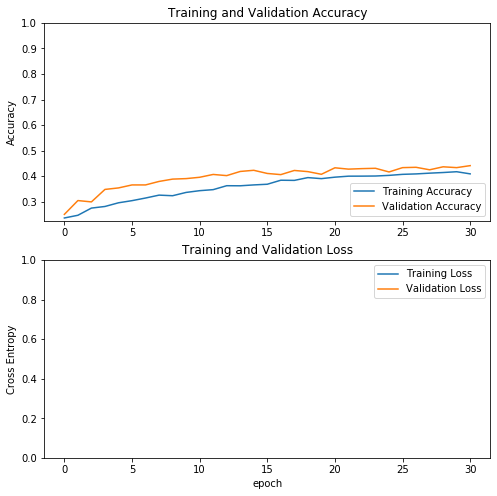

In [26]:
acc = history_mlp.history['accuracy']
val_acc = history_mlp.history['val_accuracy']

loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 7. CNN

For a CNN model, I also make a fairly simple model with `Dropout` layer as well as `kernel regularization`.

For optimizer, I use `Adam` optimizer and `EarlyStopping` as well as `ReduceLearningRateOnPlateau`

In [27]:
model_cnn = tf.keras.models.Sequential([                    
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

In [28]:
optimizer = tf.keras.optimizers.Adam()

In [29]:
model_cnn.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [30]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)      

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='max', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

In [32]:
# for windows users
!rmdir /Q/S logs

In [33]:
log_dir_cnn = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
epochs = 40

history_cnn = model_cnn.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, reduce_lr, es])

Epoch 1/40
51/51 [==============================] - 234s 5s/step - loss: 6.9843 - accuracy: 0.2754 - val_loss: 1.9994 - val_accuracy: 0.4154
Epoch 2/40
51/51 [==============================] - 232s 5s/step - loss: 1.8287 - accuracy: 0.4425 - val_loss: 1.5432 - val_accuracy: 0.4766
Epoch 3/40
51/51 [==============================] - 233s 5s/step - loss: 1.5158 - accuracy: 0.4812 - val_loss: 1.4667 - val_accuracy: 0.4928
Epoch 4/40
51/51 [==============================] - 233s 5s/step - loss: 1.4677 - accuracy: 0.4896 - val_loss: 1.4584 - val_accuracy: 0.4993
Epoch 5/40
51/51 [==============================] - 242s 5s/step - loss: 1.4539 - accuracy: 0.4983 - val_loss: 1.4598 - val_accuracy: 0.4954
Epoch 6/40
51/51 [==============================] - ETA: 0s - loss: 1.4340 - accuracy: 0.5146
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
51/51 [==============================] - 240s 5s/step - loss: 1.4341 - accuracy: 0.5145 - val_loss: 1.4964 - val_accurac

In [35]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-09-10 16:15:57.747440: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2020-09-10 16:15:57.751076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\trung\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\trung\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\trung\anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\trung\anaconda3\lib\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\trung\anaconda3\lib\site-packages\absl\app.py", line 299, in run
    _run_main(mai

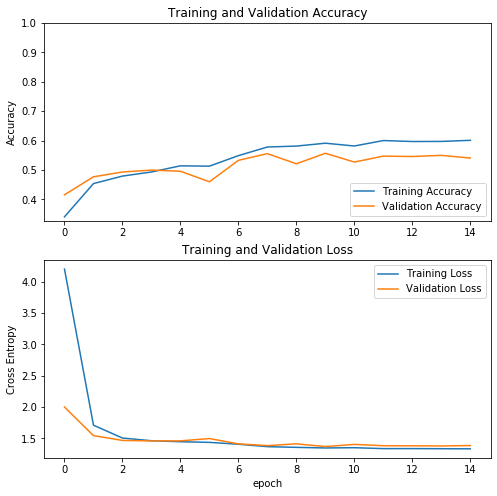

In [36]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 8. Optimization

The optimization steps had already been inlcuded in both models, such as Dropout, and learning rate scheduler, early stopping.

The CNN model is clearly outperforming the simple MLP model.

## 9. Predictions

In [37]:
test_data = pd.read_csv(base_dir + "/Testing_set_animals.csv")
len(test_data)

910

In [38]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_mlp.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,scoiattolo
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,farfalla
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,pecora
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,pecora
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,farfalla


In [39]:
test_data.to_csv('results/result_mlp.csv')

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    label = test_data.target[i]
    ax = plt.subplot(3, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)

In [41]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_cnn.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,farfalla
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,farfalla
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,farfalla
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,farfalla
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,farfalla


In [42]:
test_data.to_csv('results/result_cnn.csv')

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    label = test_data.target[i]
    ax = plt.subplot(3, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)

## 10. Transfer Learning

Here I used the pre-trained `MobileNetV2` model as the base model for the prediction. Then I added an `Input` layer with appropriate shape.

A `Global Average Pooling 2D` after the base model and followed by a `Dense` layer as the final prediction layer.

In [44]:
INPUT_SHAPE = (IMG_SHAPE, IMG_SHAPE) + (3,)

In [45]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [46]:
image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


In [47]:
base_model.trainable = False

In [48]:
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

In [49]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)


In [50]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
transfer_model = tf.keras.Model(inputs, outputs)

For first training, I used `Adam` optimizer with no extra modifications or optimization steps since the pretrained model is expected to outperform both of my models from above.

In [51]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [54]:
initial_epochs = 10

history_transfer = transfer_model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/10
52/52 [==============================] - 130s 2s/step - loss: 1.8848 - accuracy: 0.2734 - val_loss: 1.2079 - val_accuracy: 0.5171
Epoch 2/10
52/52 [==============================] - 160s 3s/step - loss: 1.1956 - accuracy: 0.5442 - val_loss: 0.7887 - val_accuracy: 0.7631
Epoch 3/10
52/52 [==============================] - 139s 3s/step - loss: 0.8282 - accuracy: 0.7232 - val_loss: 0.5730 - val_accuracy: 0.8346
Epoch 4/10
52/52 [==============================] - 141s 3s/step - loss: 0.6286 - accuracy: 0.7996 - val_loss: 0.4495 - val_accuracy: 0.8724
Epoch 5/10
52/52 [==============================] - 146s 3s/step - loss: 0.5201 - accuracy: 0.8380 - val_loss: 0.3772 - val_accuracy: 0.8913
Epoch 6/10
52/52 [==============================] - 146s 3s/step - loss: 0.4257 - accuracy: 0.8740 - val_loss: 0.3247 - val_accuracy: 0.9029
Epoch 7/10
52/52 [==============================] - 146s 3s/step - loss: 0.3804 - accuracy: 0.8745 - val_loss: 0.2939 - val_accuracy: 0.9115
Epoch 8/10
52

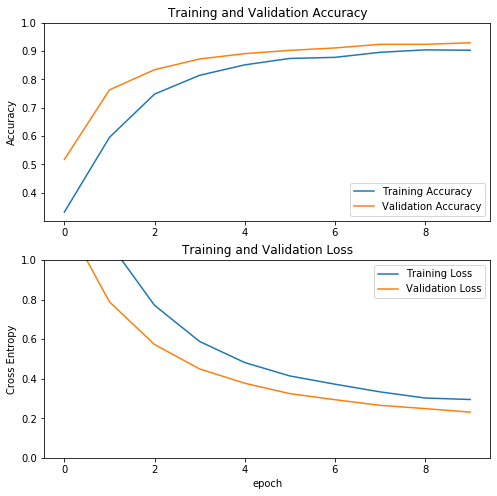

In [55]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
transfer_model.save('models/transfer_model.h5')

After initial training, I unfroze more layers in the base model for further training. This time I tried out `RMSprop` as my optimizer and reduced the learning rate since I am trying to finetune my model rather than training from scratch.

In [70]:
base_model.trainable = True

In [71]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model: 154


In [72]:
transfer_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [73]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 1,867,845
Non-trainable params: 396,544
_________________________________________________________________


In [74]:
print(f"Trainable Variables: {len(transfer_model.trainable_variables)}")

Trainable Variables: 56


In [75]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = transfer_model.fit(train_data_gen,
                         epochs=total_epochs,
                         initial_epoch=history_transfer.epoch[-1],
                         validation_data=val_data_gen)

Epoch 10/20
52/52 [==============================] - 220s 4s/step - loss: 0.2442 - accuracy: 0.9158 - val_loss: 0.1667 - val_accuracy: 0.9396
Epoch 11/20
52/52 [==============================] - 197s 4s/step - loss: 0.1712 - accuracy: 0.9451 - val_loss: 0.1489 - val_accuracy: 0.9487
Epoch 12/20
52/52 [==============================] - 217s 4s/step - loss: 0.1596 - accuracy: 0.9460 - val_loss: 0.1201 - val_accuracy: 0.9573
Epoch 13/20
52/52 [==============================] - 229s 4s/step - loss: 0.1529 - accuracy: 0.9454 - val_loss: 0.1230 - val_accuracy: 0.9536
Epoch 14/20
52/52 [==============================] - 224s 4s/step - loss: 0.1347 - accuracy: 0.9515 - val_loss: 0.1123 - val_accuracy: 0.9628
Epoch 15/20
52/52 [==============================] - 223s 4s/step - loss: 0.1219 - accuracy: 0.9555 - val_loss: 0.1183 - val_accuracy: 0.9609
Epoch 16/20
52/52 [==============================] - 284s 5s/step - loss: 0.1109 - accuracy: 0.9604 - val_loss: 0.1100 - val_accuracy: 0.9609
Epoch 

In [76]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

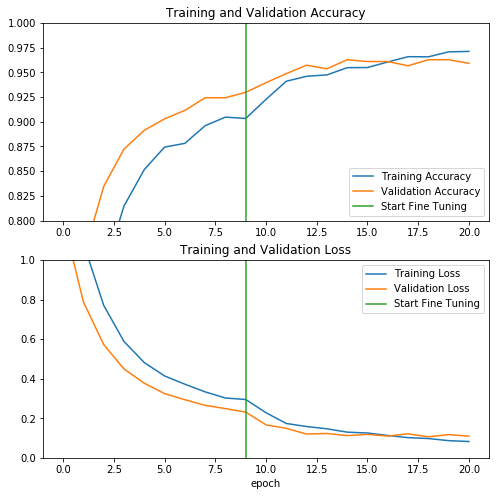

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [78]:
transfer_model.save('models/transfer_model_finetuned.h5')

In [79]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = transfer_model.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]

In [80]:
test_data.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,farfalla
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,farfalla
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,farfalla
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,farfalla
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,farfalla


In [81]:
test_data.to_csv("results/result_transfer.csv", index=False)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = test_data.filename[i+200]
    img_path = os.path.join(test_dir, img_name)
    label = test_data.target[i+200]
    ax = plt.subplot(3, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)